In [1]:
import re
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
import demoji
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Télécharger les stopwords de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adminetu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adminetu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Adminetu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
# Lire le fichier JSON
with open('comments_final1 .json', 'r', encoding='utf-8') as file:
    data = json.load(file)

In [19]:
# Initialiser des listes vides pour stocker les données
ids = []
text = []
score = []

# Parcourir les recettes dans le fichier JSON
for recipe in data:
    recipe_id = recipe["_id"]["$oid"]

    # Parcourir les commentaires de chaque recette
    for comment in recipe["comments"]:
        comment_text = comment["comment"]
        rating = comment["appreciation"]

        # Ajouter les données extraites aux listes
        ids.append(recipe_id)
        text.append(comment_text)
        score.append(rating)

# Créer la dataframe à partir des listes
data = pd.DataFrame({'id': ids, 'text': text, 'score': score})

## data cleaning et Preprocessing

In [20]:
print(data.shape)
data.drop_duplicates(subset=["text", "score"], inplace=True)

print(data.shape)

(51880, 3)
(20033, 3)


In [21]:
def cleanPunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n", " ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-ZÀ-ÿ]+', '', word)  # Inclure les caractères accentués français
        alpha_word = alpha_word.replace('œ', 'oe')  # Remplacer 'œ' par 'oe'
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    stop_words = set(stopwords.words('french'))
    return ' '.join([word for word in sentence.split() if word.lower() not in stop_words])


In [22]:
data['text'] = data['text'].apply(cleanPunc)
#data['text'] = data['text'].apply(keepAlpha)
data['text'] = data['text'].apply(removeStopWords)
data['text'] = data['text'].str.lower()
data['text'] = data['text'].apply(lambda x: re.sub(r'http\S+', '', re.sub(r'[^\w\s]|[\d]|[\r\n]', '', x)))
data['text'] = data['text'].apply(lambda x: demoji.replace(x, ""))

data['score'] = data['score'].apply(lambda x: int(x.replace('/5', '')) if isinstance(x, str) else x)
data.dropna(inplace=True)
print(data.shape)

(20033, 3)


In [23]:
data.head()

,id,text,score
0,6427813f87fbea890b1b1f7d,coool,5
1,6427813f87fbea890b1b1f7d,temps cuisson,5
2,6427813f87fbea890b1b1f7d,œufs coque cest minutes fais bouillir leau bo...,5
3,6427813f87fbea890b1b1f7d,très facile,5
4,6427813f87fbea890b1b1f7d,super trop bien,4


In [25]:
# Supprimer les caractères répétés
data['text'] = data['text'].apply(lambda x: re.sub(r'(\w)(\1{2,})', r'\1', x))
print(data.shape)
data['token_size'] = data['text'].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 200]
data = data.sample(n= 50000 , replace = True)
#fin de prétraitement

(50000, 4)


In [26]:
data.head()

,id,text,score,token_size
15984,642782a4c9d4255cb6d5694e,parfait suivi lettre encore meilleur lendemain,5,6
18318,6427846bffa4ddcd69ad5a27,jai remplacé branches céleri céleri rave finem...,5,20
20774,6427846bffa4ddcd69ad5a29,excellente tout monde beaucoup appréciée,5,5
40395,6427846bffa4ddcd69ad5a69,pure merveille consommer sans modération jai a...,5,20
16389,642782a4c9d4255cb6d5694f,cette recette bien cuits endives leau citronné...,3,34


In [27]:
data['score'].unique()

array([5, 3, 4, 2, 1], dtype=int64)

## Génération des nouveaux commentaires avec les scores les moins présents dans la dataset

In [28]:
#génération des nouveaux samples

# Séparation des données par classe
class_1_data = data[data['score'] == 1]
class_2_data = data[data['score'] == 2]
class_3_data = data[data['score'] == 3]

In [29]:
filtered_data = pd.concat([class_1_data, class_2_data, class_3_data], axis=0)

sentences = [text.split() for text in filtered_data['text']]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

generated_samples = []
generated_scores = []

In [30]:
for text in filtered_data['text']:
    words = text.split()
    generated_words = []
    for word in words:
        if word in model.wv:
            similar_words = model.wv.similar_by_word(word, topn=5)
            generated_word = similar_words[0][0]  # Sélectionner le mot le plus similaire
            generated_words.append(generated_word)
    generated_text = ' '.join(generated_words)
    generated_samples.append(generated_text)

    # Trouver le commentaire d'origine correspondant
    original_comment = filtered_data.loc[filtered_data['text'] == text]
    original_score = original_comment['score'].values[0]  # Récupérer le score du commentaire d'origine

    generated_scores.append(original_score)  # Ajouter le score à la liste des scores générés


# Créer un DataFrame avec les commentaires générés et les scores correspondants
generated_data = pd.DataFrame({'text': generated_samples, 'score': generated_scores})


In [32]:
# Créer un DataFrame avec les commentaires générés et les scores correspondants
generated_data = pd.DataFrame({'text': generated_samples, 'score': generated_scores})

# Supprimer les commentaires avec un score de 2 et seulement un mot
generated_data = generated_data.loc[(generated_data['score'] != 2) | (generated_data['text'].str.split().str.len() > 1)]


comments_count_score_2 = generated_data['score'].value_counts()[2]
print("Nombre de commentaires avec un score de 2 :", comments_count_score_2)

comments_count_score_3 = generated_data['score'].value_counts()[3]
print("Nombre de commentaires avec un score de 3 :", comments_count_score_3)

comments_count_score_1 = generated_data['score'].value_counts()[1]
print("Nombre de commentaires avec un score de 1 :", comments_count_score_1)

# Concaténer les commentaires générés avec les commentaires d'origine
combined_data = pd.concat([filtered_data, generated_data], ignore_index=True)
print(generated_data.head())
data=pd.concat([data, combined_data])

Nombre de commentaires avec un score de 2 : 607
Nombre de commentaires avec un score de 3 : 1227
Nombre de commentaires avec un score de 1 : 440
                                                text  score
0                fromage cake bien ça deau bien être      1
1  rapide si effet donc facile autant bien rapide...      1
2  peu bien si tout fait danchois tout après aprè...      1
3  ça cake bien lait fromage fais bien ça cela to...      1
4  creme pâte bien peu largement curcuma fait int...      1


In [33]:
# Construct a vocabulary
class ConstructVocab():

    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for sent in self.sentences:
            self.vocab.update(sent.split(' '))

        # sort vacabulary
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0

        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1  # 0 is the pad

        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word
inputs = ConstructVocab(data['text'].values.tolist())


input_tensor = [[inputs.word2idx[s] for s in es.split(' ')] for es in data['text']]

In [34]:
#add pading
def max_length(tensor):
    return max(len(t) for t in tensor)
max_length_input = max_length(input_tensor)

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)

    if len(x) > max_len:
        padded[:] = x[:max_len]
    else:
        padded[:len(x)] = x

    return padded

input_tensor = [pad_sequences(x, max_length_input) for x in input_tensor]

In [35]:
#binarize the target
rates = list(set(data.score.unique()))
num_rates = len(rates)
mlb = preprocessing.MultiLabelBinarizer()
data_labels = [set(rat) & set(rates) for rat in data[['score']].values]
bin_rates = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_rates.tolist())


#split the data

X_train, X_val, y_train, y_val = train_test_split(input_tensor, target_tensor, test_size=0.3, random_state=1000)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=1000)

#X_train, X_temp, y_train, y_temp = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=1000)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1000)


embedding_dim = 256
units = 256#1024
vocab_inp_size = len(inputs.word2idx)
target_size = len(target_tensor[0])

In [36]:
# Use Dataset class to represent the dataset object
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [np.sum(1 - np.equal(x, 0)) for x in X]


    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]

        return x, y, x_len


    def __len__(self):
        return len(self.data)

In [37]:
TRAIN_BUFFER_SIZE = len(X_train)
VAL_BUFFER_SIZE = len(X_val)
TEST_BUFFER_SIZE = len(X_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

train_dataset = MyData(X_train, y_train)
val_dataset = MyData(X_val, y_val)
test_dataset = MyData(X_test, y_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE,drop_last=True, shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE,drop_last=True, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE,drop_last=True, shuffle=True)

In [38]:
class RateGRU(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(RateGRU, self).__init__()
        self.batch = batch_sz
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.output_size = output_size

        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)

    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch, self.hidden_units)).to(device)

    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden)
        out = output[-1, :, :]
        out = self.dropout(out)
        out = self.fc(out)

        return out, self.hidden


In [39]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RateGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


def loss_function(y, prediction):
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target)

    return loss


def accuracy(target, logit):
    target = torch.max(target, 1)[1]
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100. * corrects / len(logit)

    return accuracy

In [40]:
EPOCHS = 10

for epoch in range(EPOCHS):

    start = time.time()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    print("debut", epoch)

    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1, 0).to(device), lens, device)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
    print("fin", epoch)
    # Calculate accuracy and loss after each epoch
    train_loss = total_loss / TRAIN_N_BATCH
    train_acc = train_accuracy / TRAIN_N_BATCH

    # Evaluation on validation set
    val_loss = 0
    val_accuracy = 0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for (val_inp, val_targ, val_lens) in val_dataset:
            val_pred, _ = model(val_inp.permute(1, 0).to(device), val_lens, device)
            val_loss += loss_function(val_targ.to(device), val_pred)

            val_accuracy += accuracy(val_targ.to(device), val_pred)
            val_predictions.extend(torch.argmax(val_pred, dim=1).cpu().numpy())
            val_targets.extend(torch.argmax(val_targ, dim=1).cpu().numpy())

    val_loss /= VAL_N_BATCH
    val_acc = val_accuracy / VAL_N_BATCH

    # Print accuracy and loss
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} - Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.2f}%")

    # Calculate and print confusion matrix
    cm = confusion_matrix(val_targets, val_predictions)
    print("Confusion Matrix:")
    print(cm)
    # plot confusion matrix
    #plt.figure(figsize=(6, 4))
    #target_names = [str(i) for i in range(target_size)]
    #sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=target_names, yticklabels=target_names)
    #plt.title("Confusion Matrix")
    #plt.xlabel("Predicted")
    #plt.ylabel("True")
    #plt.show()

    # Print classification report
    target_names = [str(i) for i in range(target_size)]
    report = classification_report(val_targets, val_predictions, target_names=target_names, zero_division=1)
    print("Classification Report:")
    print(report)

debut 0
fin 0
Epoch 1/10
Train Loss: 0.1593 - Train Accuracy: 73.19%
Validation Loss: 0.6019 - Validation Accuracy: 76.53%
Confusion Matrix:
[[   4   60  212    2   38]
 [   4  114  334   10   17]
 [  15  195  626   15   53]
 [   3   14   69   73  968]
 [   1    5   28   30 5942]]
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.01      0.02       316
           1       0.29      0.24      0.26       479
           2       0.49      0.69      0.58       904
           3       0.56      0.06      0.12      1127
           4       0.85      0.99      0.91      6006

    accuracy                           0.77      8832
   macro avg       0.47      0.40      0.38      8832
weighted avg       0.72      0.77      0.71      8832

debut 1
fin 1
Epoch 2/10
Train Loss: 0.0941 - Train Accuracy: 82.79%
Validation Loss: 0.3694 - Validation Accuracy: 87.57%
Confusion Matrix:
[[ 145   14   98   38   21]
 [  17  382   59   16    7]
 [  23   

In [41]:
# Chemin de sauvegarde du modèle
model_path = 'modele.pt'

# Sauvegarde du modèle
torch.save(model.state_dict(), model_path)

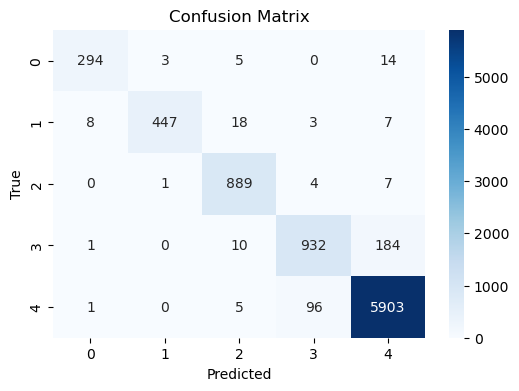

In [42]:
#plot confusion matrix
plt.figure(figsize=(6, 4))
target_names = [str(i) for i in range(target_size)]
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()